## Загрузим нужные библиотеки

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', None)

/Users/is_macbook/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df_train = pd.read_csv("content/train_dataset_train.csv") # обучающий датасет
df_sample_solution = pd.read_csv("content/sample_solution.csv") # 

df_named = pd.read_csv("content/named.csv", infer_datetime_format=True) #
df_type_contract = pd.read_csv("content/type_contract.csv") #
df_log = pd.read_csv("content/log.csv", infer_datetime_format=True) #

## Рассмотрим датасет по ближе

In [4]:
df_train.head(3)

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


<AxesSubplot:xlabel='blocked'>

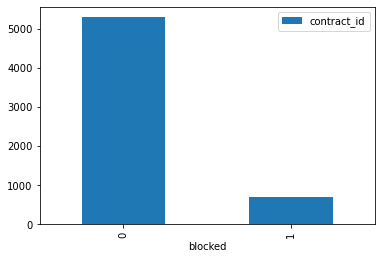

In [5]:
res_df_train = df_train.groupby('blocked').agg('count')
res_df_train.plot.bar()

In [6]:
res_df_train

,contract_id
blocked,
0,5294
1,698


Доля ушедших клиентов составляет 11,6%

In [7]:
df_named.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [8]:
# изменение формата даты
df_named.date = pd.to_datetime(df_named.date, infer_datetime_format=True)

In [9]:
df_named.head(3)

,date,url,contract_id
0,2021-04-17,webmail.sampo.ru,101397
1,2021-04-17,webmail.sampo.ru,179624
2,2021-04-17,tvip-provision.sampo.ru,190335


<AxesSubplot:xlabel='date'>

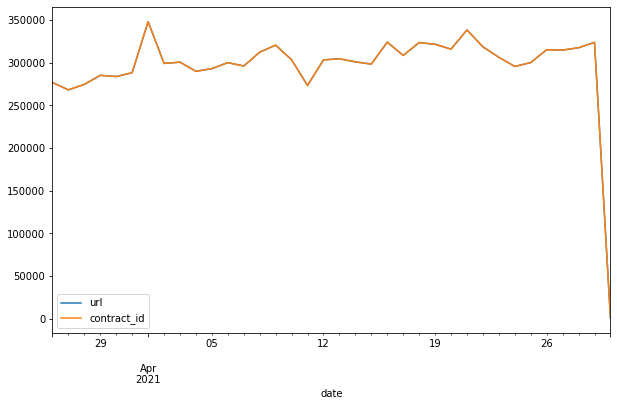

In [10]:
df_named.groupby('date').count().plot(figsize=(10,6))

За последний день апреля 2021 года в датасете значительно меньше данных, чем за прочие дни

In [11]:
df_named.groupby('url')['contract_id'].count().nlargest(15)

url
camera.rt.ru                    7333195
vmxott.svc.iptv.rt.ru            289876
tvip-provision.sampo.ru          138944
webmail.sampo.ru                 132718
statserv.sampo.ru                110428
193755.16.rt.ru                  106464
_sip._udp.193755.16.rt.ru        104596
_sip._tcp.193755.16.rt.ru        101820
530237.16.rt.ru                   99694
048056.16.rt.ru                   98511
_sip._udp.048056.16.rt.ru         98047
st44-broadcast.sampo.ru           74756
fe-nw.svc.iptv.rt.ru              68216
navigator.sampo.ru                64993
sz-ptzv-itv02.svc.iptv.rt.ru      63270
Name: contract_id, dtype: int64

In [12]:
# добавляю фичу с сокращенным доменом
df_named['dest'] = df_named['url'].str.extract('(rt.ru)').fillna('sampo.ru')

In [136]:
df_named.head(1)

,date,url,contract_id,dest
0,2021-04-17,webmail.sampo.ru,101397,sampo.ru


In [13]:
df_type_contract.head(3)

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0


<AxesSubplot:xlabel='day_or_month_contract'>

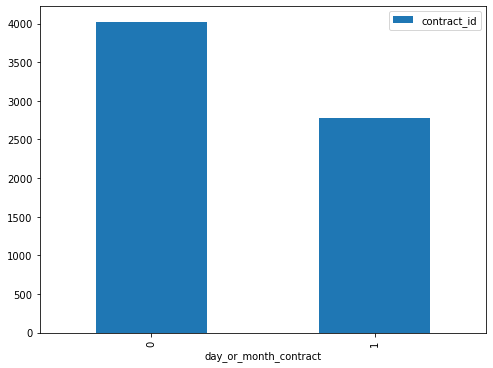

In [14]:
df_type_contract.groupby('day_or_month_contract').count().plot.bar(figsize=(8,6))

Аудитория клиентов с помесячной тарификацией превышает аудиторию с подневным тарифом 

In [15]:
df_log.head(3)

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета


<AxesSubplot:ylabel='event_type'>

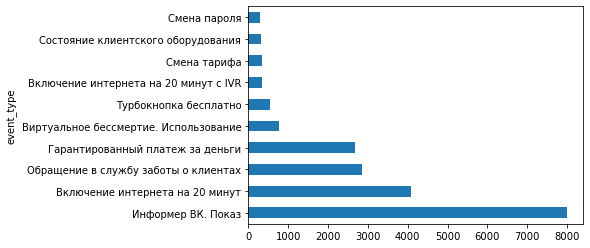

In [16]:
# обзор самых популярных обращений
df_log.groupby(['event_type'])['contract_id'].count().nlargest(10).plot.barh()

In [17]:
# добавление фичи, которая маркирует популярные обращения свыше 1000

pop_log_list = ['Информер ВК. Показ', 'Включение интернета на 20 минут',
                'Обращение в службу заботы о клиентах', 'Гарантированный платеж за деньги']

def mark_pop_log(n):
    if n in pop_log_list:
        return 1
    else:
        return 0
    
df_log['popular_log'] = df_log.apply(lambda x: mark_pop_log(x.event_type), axis=1)

In [18]:
# убираю время из даты обращения
df_log['event_date'] = pd.to_datetime(df_log.event_date, format='%Y-%m-%d').dt.date

In [19]:
df_log.event_date = pd.to_datetime(df_log.event_date, infer_datetime_format=True)

In [20]:
df_log.head(3)

,contract_id,event_date,event_type,popular_log
0,36294,2021-03-28,Добавление в Обращались с номеров,0
1,36294,2021-03-28,Обращение в службу заботы о клиентах,1
2,36294,2021-03-28,Выключение IPTV-пакета,0


Узнаем размерность наборов

In [21]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 4)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 4)


In [22]:
df_type_contract.contract_id.nunique()

6800

В датасете df_type_contract содержится больше записей, чем в обучающем датасете. Предполагаю, что остальные записи хранятся в тестовом датасете

In [23]:
# обзор тестового датасета
df_sample_solution.head(5)

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0


<AxesSubplot:>

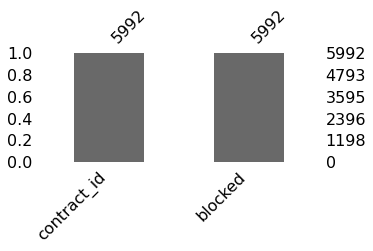

In [24]:
# обзор пропущенных значений
msno.bar(df_train, figsize=(5,2))

<AxesSubplot:>

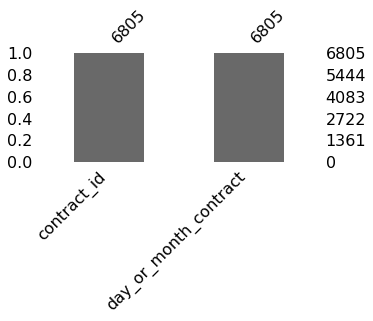

In [25]:
msno.bar(df_type_contract, figsize=(5,2))

<AxesSubplot:>

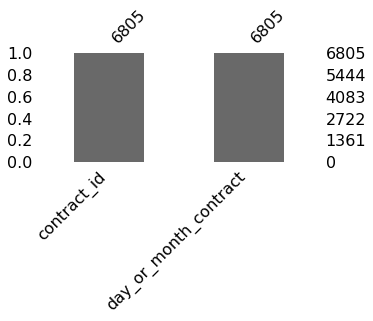

In [26]:
msno.bar(df_type_contract, figsize=(5,2))

<AxesSubplot:>

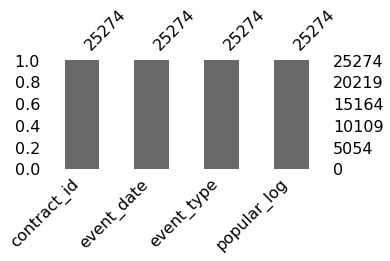

In [27]:
msno.bar(df_log, figsize=(5,2))

В датасетах нет пропущенных данных

### Видоизмение данных

Обьединим два набора с данными

In [28]:
# объединение 
train = pd.merge(df_train, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id").fillna(0)

# возврат столбца к формату int
train.day_or_month_contract = train.day_or_month_contract.astype(int)

train.head(3)

,contract_id,blocked,day_or_month_contract
0,7780,0,0
1,7785,0,0
2,7794,0,0


Добавим столбец - колличество обращений человека

In [29]:
count_log = df_log.groupby("contract_id").count()

count_log.head(3)

,event_date,event_type,popular_log
contract_id,,,
3453,1,1,1
3454,1,1,1
3456,4,4,4


<AxesSubplot:>

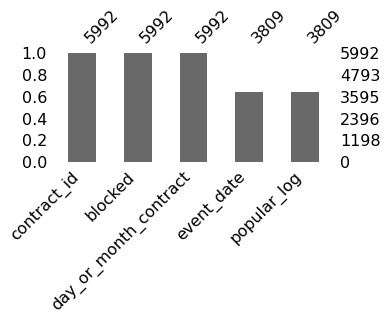

In [30]:
train = pd.merge(train, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)

# график пропущенных значений
msno.bar(train, figsize=(5,2))

Заменим пропуски на нули и переименуем колонку

In [31]:
train = train.fillna(0)
train.rename(columns={"event_date": "event_count"}, inplace=True)

In [32]:
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
#= pd.get_dummies(df_named.dest)
named_transform.head(5)

,dest_rt.ru,dest_sampo.ru
contract_id,,
3455,5.0,19.0
3458,1.0,0.0
3459,1.0,1.0
3460,0.0,10.0
3461,1.0,0.0


In [33]:
named_transform.shape

(196148, 2)

In [34]:
named_transform = named_transform.drop_duplicates(keep='first')

<AxesSubplot:>

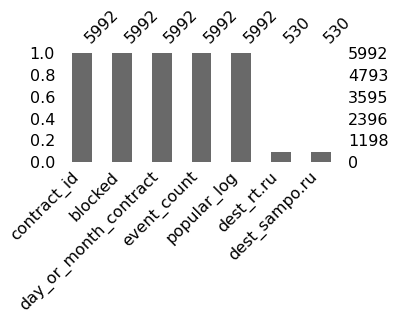

In [35]:
train = pd.merge(train, named_transform , on="contract_id", how='left')

# график пропущенных значений
msno.bar(train, figsize=(5,2))

<AxesSubplot:>

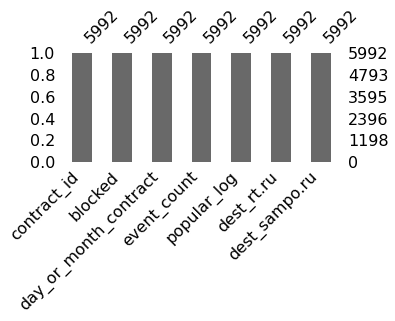

In [36]:
train.fillna(0, inplace=True)
msno.bar(train, figsize=(5,2))

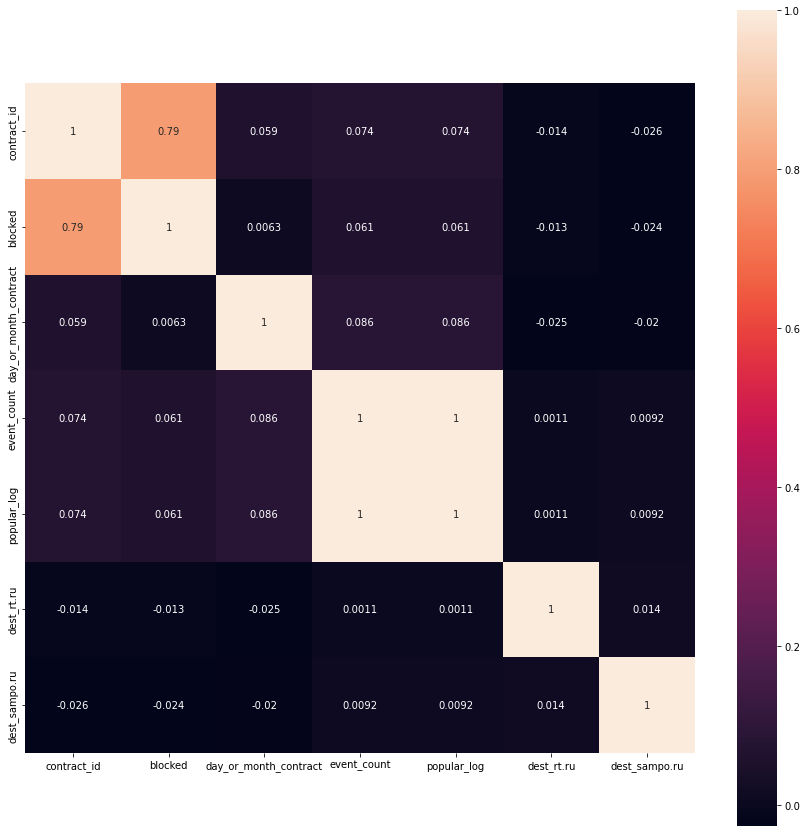

In [37]:
plt.rcParams['figure.figsize']=(15,15)

corr = train.corr()
g = sns.heatmap(corr, square = True, annot=True)

Рассмотрим корреляцию по ушедшим клиентам

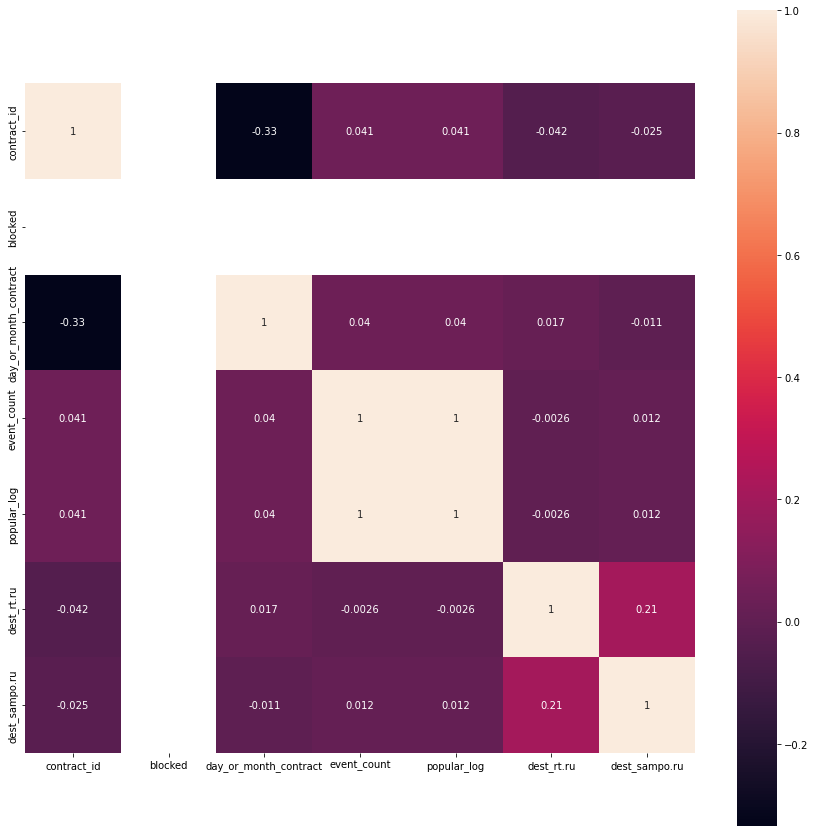

In [160]:
plt.rcParams['figure.figsize']=(15,15)

corr = train[train.blocked==1].corr()
g = sns.heatmap(corr, square = True, annot=True)

Наиболее явные признаки коррелирующие с переходом клиента к другому провайдеру содержатся в столбцах с количеством обращений клиентов, в тч обзор популярных обращений и переходы в домен конкурентов

## Выделим выборки

In [39]:
X = train.drop(['contract_id', "blocked"], axis = 1)
y = train[["blocked"]]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [42]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
xgb = XGBClassifier(eta=0.01,
                   eval_metric='auc', 
                   verbosity=2).fit(X_train, y_train,
                         eval_set=[(X_test, y_test)])

[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.60266
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.60266
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.60266
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.60266


[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[33]	validation_0-auc:0.60265
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[34]	validation_0-auc:0.60265
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[35]	validation_0-auc:0.60265
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[36]	validation_0-auc:0.60

[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[66]	validation_0-auc:0.59654
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[67]	validation_0-auc:0.59654
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[68]	validation_0-auc:0.59654
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[69]	validation_0-auc:0.59

[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[99]	validation_0-auc:0.60104


In [300]:
pool_full_train = Pool(data=train.drop(["blocked"], axis = 1),
                      label=train[["blocked"]])


In [44]:
# 
cbc = CatBoostClassifier(#iterations=1000,
                         learning_rate=0.01, 
                         #depth=8,
                         loss_function='CrossEntropy',
                         eval_metric='Recall')

cbc.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 63.1ms	remaining: 1m 3s
100:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 234ms	remaining: 2.08s
200:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 396ms	remaining: 1.57s
300:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 559ms	remaining: 1.3s
400:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 718ms	remaining: 1.07s
500:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 879ms	remaining: 876ms
600:	learn: 0.0082474	test: 0.0000000	best: 0.0000000 (0)	total: 1.05s	remaining: 700ms
700:	learn: 0.0103093	test: 0.0000000	best: 0.0000000 (0)	total: 1.25s	remaining: 536ms
800:	learn: 0.0123711	test: 0.0000000	best: 0.0000000 (0)	total: 1.42s	remaining: 353ms
900:	learn: 0.0123711	test: 0.0000000	best: 0.0000000 (0)	total: 1.59s	remaining: 175ms
999:	learn: 0.0144330	test: 0.0000000	best: 0.0000000 (0)	total: 1.75s	remaining: 0us

bestTest = 0
bestIteration = 0

Shr

In [322]:
cbc.get_params()

{'learning_rate': 0.01,
 'loss_function': 'CrossEntropy',
 'eval_metric': 'Recall'}

In [321]:
# проверка обученности модели
cbc.is_fitted()

True

## Оценка точности

In [45]:
pred = clf.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
pred_cbc = cbc.predict(X_test)
pred_cbc

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
pred_xgb = xgb.predict(X_test)
pred_xgb

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.49873817034700313


In [49]:
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.5


In [50]:
print("Recall score:", recall_score(y_test, pred_xgb, average='macro'))

Recall score: 0.5


# Предсказание на тестовом наборе

In [312]:
# объединение 
test = pd.merge(df_sample_solution, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id").fillna(0)

# возврат столбца к формату int
test.day_or_month_contract = test.day_or_month_contract.astype(int)

test = pd.merge(test, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)


test.rename(columns={"event_date": "event_count"}, inplace=True)

named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()

test = pd.merge(test, named_transform , on="contract_id", how='left')
#= pd.get_dummies(df_named.dest)
test = test.fillna(0)
test = test.astype(int)

In [313]:
test

,contract_id,blocked,day_or_month_contract,event_count,popular_log,dest_rt.ru,dest_sampo.ru
0,3453,0,0,1,1,0,0
1,3454,0,1,1,1,0,0
2,3455,0,1,0,0,5,19
3,3456,0,0,4,4,0,0
4,3457,0,0,4,4,0,0
...,...,...,...,...,...,...,...
805,4258,0,1,3,3,0,0
806,4259,0,1,0,0,8,476
807,4260,0,0,3,3,0,9
808,4261,0,0,18,18,0,0


In [325]:
pool_test_solution = Pool(data=test.drop(["blocked"], axis = 1),
                      )

In [329]:
test.drop(["blocked"], axis = 1)

,contract_id,day_or_month_contract,event_count,popular_log,dest_rt.ru,dest_sampo.ru
0,3453,0,1,1,0,0
1,3454,1,1,1,0,0
2,3455,1,0,0,5,19
3,3456,0,4,4,0,0
4,3457,0,4,4,0,0
...,...,...,...,...,...,...
805,4258,1,3,3,0,0
806,4259,1,0,0,8,476
807,4260,0,3,3,0,9
808,4261,0,18,18,0,0


In [330]:
cbc_test = cbc.predict(test.drop(["blocked"], axis = 1))

In [336]:
pred_clf = clf.predict(test.drop(["blocked"], axis = 1))
pred_clf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [337]:
pred_xgb2 = xgb.predict(test.drop(["blocked"], axis = 1))
pred_xgb2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [335]:
solution_data = pd.DataFrame(test.contract_id)
solution_data['blocked'] = pd.Series(cbc_test)
solution_data

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,0


In [163]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler

x2 = train.drop(['contract_id','blocked'], axis=1)
y2 = train.blocked

# выполню стандартизацию для сглаживания данных
x2 = StandardScaler().fit_transform(x2)

# SMOTE
X_resampled_s, y_resampled_s = SMOTE().fit_resample(x2, y2)

# ADASYN
X_resampled_a, y_resampled_a = ADASYN().fit_resample(x2, y2)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_a, y_resampled_a, test_size=0.3, random_state=47)

In [165]:
cbc = CatBoostClassifier(iterations=2000,
                         learning_rate=0.008, 
                         depth=10,
                         #eta=0.002,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'
                         #,use_best_model=True
                        )

cbc.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7483770	test: 0.7206875	best: 0.7206875 (0)	total: 10.9ms	remaining: 21.8s
100:	learn: 0.7512334	test: 0.7231430	best: 0.7243708 (5)	total: 755ms	remaining: 14.2s
200:	learn: 0.7533108	test: 0.7262124	best: 0.7262124 (195)	total: 1.59s	remaining: 14.2s
300:	learn: 0.7559076	test: 0.7274401	best: 0.7274401 (207)	total: 2.32s	remaining: 13.1s
400:	learn: 0.7595430	test: 0.7292818	best: 0.7298956 (383)	total: 3.04s	remaining: 12.1s
500:	learn: 0.7629187	test: 0.7305095	best: 0.7305095 (482)	total: 3.75s	remaining: 11.2s
600:	learn: 0.7657751	test: 0.7323511	best: 0.7323511 (579)	total: 4.47s	remaining: 10.4s
700:	learn: 0.7652558	test: 0.7335789	best: 0.7335789 (644)	total: 5.19s	remaining: 9.63s
800:	learn: 0.7657751	test: 0.7341928	best: 0.7341928 (778)	total: 5.93s	remaining: 8.88s
900:	learn: 0.7662945	test: 0.7366483	best: 0.7366483 (898)	total: 6.63s	remaining: 8.09s
1000:	learn: 0.7670735	test: 0.7378760	best: 0.7378760 (1000)	total: 7.36s	remaining: 7.34s
1100:	learn: 

In [221]:
pred_cbc = cbc.predict(X_test)
pred_cbc
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.9986174920575717


In [222]:
clf = RandomForestClassifier(n_estimators=5000
                             ,max_depth=12
                             #,min_samples_split=6
                             #,min_samples_leaf=1
                             ,random_state=42
                             ,criterion='log_loss'
                            )
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print("Recall score:", recall_score(y_test, predict, average='macro'))

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [168]:
from sklearn.neighbors import KNeighborsClassifier

# инициация модели
knc = KNeighborsClassifier().fit(X_train, y_train)

# получение предсказанных результатов
knc_predict = knc.predict(X_test)
print("Recall score:", recall_score(y_test, knc_predict, average='macro'))

Recall score: 0.5699532629445416


# Обучение на обогащенном датасете

Гипотеза заключается в том, что полноту (Recall) можно повысить благодаря сбору датасета без очищения от дублей, но с новыми фичами, которые сгенерировали ранее. На большем объеме данных модель может лучше найти взаимосвязи, также планирую оставить даты в наборе данных и применить модель CatBoostClassifier, которая может работать с категориальными признаками в необработанном виде.

In [223]:
train_full = df_train.copy()
train_full = train_full.merge(df_log, on='contract_id')
train_full = train_full.merge(df_named, on='contract_id')
train_full = train_full.merge(df_type_contract, on='contract_id')
train_full = train_full.merge(count_log , on="contract_id")
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
train_full = train_full.merge(named_transform , on="contract_id")
train_full['dest_rt.ru'] = train_full['dest_rt.ru'].astype(int)
train_full['dest_sampo.ru'] = train_full['dest_sampo.ru'].astype(int)
train_full.drop(['event_date_y', 'event_type_y'], axis=1, inplace=True)
train_full.rename(columns={'event_date_x': 'event_date', 'popular_log_x': 'popular_log',
                           'popular_log_y': 'event_count', 'event_type_x': 'event_type'}, inplace=True)

categorial_features = ['event_type', 'url', 'dest']

train_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru
0,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,start.sampo.ru,sampo.ru,0,9,0,83
1,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,profile.sampo.ru,sampo.ru,0,9,0,83
2,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,vhod.sampo.ru,sampo.ru,0,9,0,83
3,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,kino.sampo.ru,sampo.ru,0,9,0,83
4,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,lk.sampo.ru,sampo.ru,0,9,0,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569297,274786,1,2021-04-28,Обращение в службу заботы о клиентах,1,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0
569298,274786,1,2021-04-29,Обращение в службу заботы о клиентах,1,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0
569299,274786,1,2021-04-25,Включение интернета на 20 минут с IVR,0,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0
569300,274786,1,2021-04-26,Информер ВК. Показ,1,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0


Просмотр списка из 10 самых попрулярных событий у ушедших клиентов

In [185]:
train_full.query('blocked == 1').groupby('event_type')['contract_id'].count().nlargest(10)

event_type
Информер ВК. Показ                       7652
Обращение в службу заботы о клиентах     3111
Включение интернета на 20 минут          2800
Гарантированный платеж за деньги         1888
Включение интернета на 20 минут с IVR     678
Внутреннее сообщение                      555
Добавление в Обращались с номеров         489
Оборудование                              349
Активация ГП с IVR                        334
Отключение услуги Аренда ТВ-приставки     328
Name: contract_id, dtype: int64

In [224]:
# сбор списка значений для новой фичи
list_blocked_event = ['Информер ВК. Показ', 'Обращение в службу заботы о клиентах',
                     'Включение интернета на 20 минут', 'Гарантированный платеж за деньги',
                     'Включение интернета на 20 минут с IVR', 'Внутреннее сообщение',
                     'Добавление в Обращались с номеров', 'Оборудование', 'Активация ГП с IVR',
                     'Отключение услуги Аренда ТВ-приставки']

In [225]:
def mark_pop_log_blocked(n):
    if n in pop_log_list:
        return 1
    else:
        return 0
    
train_full['popular_log_blocked'] = train_full.apply(lambda x: mark_pop_log_blocked(x.event_type), axis=1)

In [226]:
train_full.query('blocked==1').head(5)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru
109950,10798,1,2021-04-07,Обращение в службу заботы о клиентах,1,1,2021-04-12,data.sampo.ru,sampo.ru,0,5,1,1
109951,10798,1,2021-04-07,Обращение в службу заботы о клиентах,1,1,2021-04-19,fnc.rt.ru,rt.ru,0,5,1,1
109952,10798,1,2021-04-07,Предложение тарифа,0,0,2021-04-12,data.sampo.ru,sampo.ru,0,5,1,1
109953,10798,1,2021-04-07,Предложение тарифа,0,0,2021-04-19,fnc.rt.ru,rt.ru,0,5,1,1
109954,10798,1,2021-04-24,Информер ВК. Показ,1,1,2021-04-12,data.sampo.ru,sampo.ru,0,5,1,1


In [227]:
train_full.query('blocked == 1').groupby('url')['contract_id'].count().nlargest(15)

url
kino.swap.sampo.ru         2194
kino.sampo.ru              1218
fnc.rt.ru                   783
vmx.svc.iptv.rt.ru          732
sampo.ru                    709
statserv.sampo.ru           641
af.rt.ru                    609
moigorod.sampo.ru           600
mlk.rt.ru                   582
navigator.sampo.ru          580
swap.sampo.ru               579
lk.sampo.ru                 505
ice.sampo.ru                443
st44-broadcast.sampo.ru     425
ohrana.sampo.ru             423
Name: contract_id, dtype: int64

In [228]:
pop_list_url = list['kino.swap.sampo.ru', 'kino.sampo.ru', 'fnc.rt.ru', 'vmx.svc.iptv.rt.ru',
            'sampo.ru', 'statserv.sampo.ru', 'af.rt.ru', 'moigorod.sampo.ru', 'mlk.rt.ru',
            'navigator.sampo.ru', 'swap.sampo.ru', 'lk.sampo.ru', 'ice.sampo.ru', 'st44-broadcast.sampo.ru',
            'ohrana.sampo.ru']

In [229]:
def mark_pop_url_blocked(n):
    if n in pop_log_list:
        return 1
    else:
        return 0
    
train_full['popular_url_blocked'] = train_full.apply(lambda x: mark_pop_url_blocked(x.event_type), axis=1)

In [230]:
X_train, X_test, y_train, y_test = train_test_split(train_full.drop(['contract_id', 'blocked'], axis=1)
                                                    , train_full.blocked
                                                    , test_size=0.3, random_state=47)

pool_train_2 = Pool(data=X_train, label=y_train, 
                    cat_features=categorial_features)
pool_test_2 = Pool(data=X_test, label=y_test, 
                   cat_features=categorial_features)

In [174]:
x_full = train_full.drop(['contract_id', "blocked"], axis = 1)
y_full = train_full["blocked"]

# SMOTE
X_resampled_s, y_resampled_s = SMOTE().fit_resample(x_full, y_full)

# ADASYN
X_resampled_a, y_resampled_a = ADASYN().fit_resample(x_full, y_full)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [231]:
cbc = CatBoostClassifier(iterations=1000,
                         learning_rate=0.008, 
                         depth=10,
                         #eta=0.002,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'
                         #,scale_pos_weight=1.0
                         #,use_best_model=True
                        )

cbc.fit(pool_train_2,#X_train, y_train,
        eval_set=pool_test_2,
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9870244	test: 0.9868345	best: 0.9868345 (0)	total: 216ms	remaining: 7m 11s
100:	learn: 0.9945465	test: 0.9942130	best: 0.9943576 (24)	total: 24.5s	remaining: 7m 41s
200:	learn: 0.9948599	test: 0.9945023	best: 0.9952257 (111)	total: 49.3s	remaining: 7m 21s
300:	learn: 0.9977434	test: 0.9972512	best: 0.9972512 (282)	total: 1m 13s	remaining: 6m 56s
400:	learn: 0.9986836	test: 0.9978299	best: 0.9978299 (344)	total: 1m 37s	remaining: 6m 30s
500:	learn: 0.9989344	test: 0.9984086	best: 0.9984086 (490)	total: 2m 1s	remaining: 6m 4s
600:	learn: 0.9992478	test: 0.9986979	best: 0.9986979 (540)	total: 2m 26s	remaining: 5m 40s
700:	learn: 0.9993732	test: 0.9989873	best: 0.9989873 (661)	total: 2m 50s	remaining: 5m 16s
800:	learn: 0.9995612	test: 0.9994213	best: 0.9994213 (784)	total: 3m 14s	remaining: 4m 51s
900:	learn: 0.9997493	test: 0.9989873	best: 0.9994213 (784)	total: 3m 39s	remaining: 4m 28s
1000:	learn: 0.9998746	test: 0.9991319	best: 0.9994213 (784)	total: 4m 6s	remaining: 4m 5s

In [233]:
cbc.get_params()

{'iterations': 2000,
 'learning_rate': 0.008,
 'depth': 10,
 'loss_function': 'Logloss',
 'auto_class_weights': 'Balanced',
 'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
 'eval_metric': 'Recall'}

In [234]:
pred_cbc = cbc.predict(X_test)
pred_cbc
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.9972454146527033


Результат значительно лучше чем в прошлые попытки (скоры 0.5 и 0.6), в которых пробовал логику из бейзлайна, во втором случае стандартизировал датасет и ресемплировал данные для балансировки классов 0 и 1

# Предсказание на тестовом наборе

In [235]:
test_full = df_sample_solution.copy()
test_full = test_full.merge(df_log, on='contract_id', how='left').fillna(0)
test_full = test_full.merge(df_named, on='contract_id', how='left').fillna(0)
test_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest
0,3453,0,2021-03-03 00:00:00,Информер ВК. Показ,1.0,1.0,0,0,0
1,3454,0,2021-04-28 00:00:00,Внутреннее сообщение,0.0,1.0,0,0,0
2,3455,0,0,0,0.0,0.0,2021-04-25 00:00:00,swap.sampo.ru,sampo.ru
3,3455,0,0,0,0.0,0.0,2021-04-08 00:00:00,kino.sampo.ru,sampo.ru
4,3455,0,0,0,0.0,0.0,2021-04-08 00:00:00,go.sampo.ru,sampo.ru
...,...,...,...,...,...,...,...,...,...
51503,4261,0,2021-03-29 00:00:00,Информер ВК. Показ,1.0,1.0,0,0,0
51504,4261,0,2021-03-29 00:00:00,Информер ВК. Показ,1.0,1.0,0,0,0
51505,4261,0,2021-03-31 00:00:00,Включение интернета на 20 минут,1.0,1.0,0,0,0
51506,4262,0,2021-03-16 00:00:00,Включение интернета на 20 минут,1.0,1.0,0,0,0


In [236]:
test_full = df_sample_solution.copy()
test_full = test_full.merge(df_log, on='contract_id', how='left')#.fillna(0)
test_full = test_full.merge(df_named, on='contract_id', how='left')#.fillna(0)
test_full = test_full.merge(df_type_contract, on='contract_id', how='left')#.fillna(0)
test_full = test_full.merge(count_log , on="contract_id", how='left')#.fillna(0)
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
test_full = test_full.merge(named_transform , on="contract_id", how='left')#.fillna(0)
#test_full['dest_rt.ru'] = test_full['dest_rt.ru'].astype(int)
#test_full['dest_sampo.ru'] = test_full['dest_sampo.ru'].astype(int)
test_full.drop(['event_date_y', 'event_type_y'], axis=1, inplace=True)
test_full.rename(columns={'event_date_x': 'event_date', 'popular_log_x': 'popular_log',
                           'popular_log_y': 'event_count', 'event_type_x': 'event_type'}, inplace=True)
#test_full['event_count'] = test_full['event_count'].astype(int)

test_full['popular_log_blocked'] = test_full.apply(lambda x: mark_pop_log_blocked(x.event_type), axis=1)
test_full['popular_url_blocked'] = test_full.apply(lambda x: mark_pop_url_blocked(x.event_type), axis=1)

categorial_features = ['event_type', 'url', 'dest']

test_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,popular_url_blocked
0,3453,0,2021-03-03,Информер ВК. Показ,1.0,1,NaT,NaN,NaN,0,1.0,NaN,NaN,1
1,3454,0,2021-04-28,Внутреннее сообщение,0.0,0,NaT,NaN,NaN,1,1.0,NaN,NaN,0
2,3455,0,NaT,NaN,NaN,0,2021-04-25,swap.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
3,3455,0,NaT,NaN,NaN,0,2021-04-08,kino.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
4,3455,0,NaT,NaN,NaN,0,2021-04-08,go.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51951,4261,0,2021-03-29,Информер ВК. Показ,1.0,1,NaT,NaN,NaN,0,18.0,NaN,NaN,1
51952,4261,0,2021-03-29,Информер ВК. Показ,1.0,1,NaT,NaN,NaN,0,18.0,NaN,NaN,1
51953,4261,0,2021-03-31,Включение интернета на 20 минут,1.0,1,NaT,NaN,NaN,0,18.0,NaN,NaN,1
51954,4262,0,2021-03-16,Включение интернета на 20 минут,1.0,1,NaT,NaN,NaN,0,2.0,NaN,NaN,1


In [237]:
test_full.event_date = test_full.event_date.fillna(test_full.date,axis=0)
test_full.event_date = test_full.event_date.fillna(test_full.event_date.mean())
test_full.date = test_full.date.fillna(test_full.event_date,axis=0)
test_full.date = test_full.date.fillna(test_full.date.mean())
test_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,popular_url_blocked
0,3453,0,2021-03-03,Информер ВК. Показ,1.0,1,2021-03-03,NaN,NaN,0,1.0,NaN,NaN,1
1,3454,0,2021-04-28,Внутреннее сообщение,0.0,0,2021-04-28,NaN,NaN,1,1.0,NaN,NaN,0
2,3455,0,2021-04-25,NaN,NaN,0,2021-04-25,swap.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
3,3455,0,2021-04-08,NaN,NaN,0,2021-04-08,kino.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
4,3455,0,2021-04-08,NaN,NaN,0,2021-04-08,go.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51951,4261,0,2021-03-29,Информер ВК. Показ,1.0,1,2021-03-29,NaN,NaN,0,18.0,NaN,NaN,1
51952,4261,0,2021-03-29,Информер ВК. Показ,1.0,1,2021-03-29,NaN,NaN,0,18.0,NaN,NaN,1
51953,4261,0,2021-03-31,Включение интернета на 20 минут,1.0,1,2021-03-31,NaN,NaN,0,18.0,NaN,NaN,1
51954,4262,0,2021-03-16,Включение интернета на 20 минут,1.0,1,2021-03-16,NaN,NaN,0,2.0,NaN,NaN,1


In [211]:
# подсчет заполненных значений
test_full.count()

contract_id              51956
blocked                  51956
event_date               51956
event_type               45625
popular_log              45625
popular_log_blocked      51956
date                     51956
url                      49603
dest                     49603
day_or_month_contract    51956
event_count              45625
dest_rt.ru               49603
dest_sampo.ru            49603
popular_url_blocked      51956
dtype: int64

In [212]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51956 entries, 0 to 51955
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   contract_id            51956 non-null  int64         
 1   blocked                51956 non-null  int64         
 2   event_date             51956 non-null  datetime64[ns]
 3   event_type             45625 non-null  object        
 4   popular_log            45625 non-null  float64       
 5   popular_log_blocked    51956 non-null  int64         
 6   date                   51956 non-null  datetime64[ns]
 7   url                    49603 non-null  object        
 8   dest                   49603 non-null  object        
 9   day_or_month_contract  51956 non-null  int64         
 10  event_count            45625 non-null  float64       
 11  dest_rt.ru             49603 non-null  float64       
 12  dest_sampo.ru          49603 non-null  float64       
 13  p

In [238]:
test_full['event_date'] = test_full['event_date'].astype(object).where(test_full['event_date'].notnull(),np.nan)
test_full['date'] = test_full['date'].astype(object).where(test_full['date'].notnull(),np.nan)
#test_full.event_date = test_full.event_date.to_string()
#test_full.date = pd.to_datetime(test_full.date)
test_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,popular_url_blocked
0,3453,0,2021-03-03 00:00:00,Информер ВК. Показ,1.0,1,2021-03-03 00:00:00,NaN,NaN,0,1.0,NaN,NaN,1
1,3454,0,2021-04-28 00:00:00,Внутреннее сообщение,0.0,0,2021-04-28 00:00:00,NaN,NaN,1,1.0,NaN,NaN,0
2,3455,0,2021-04-25 00:00:00,NaN,NaN,0,2021-04-25 00:00:00,swap.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
3,3455,0,2021-04-08 00:00:00,NaN,NaN,0,2021-04-08 00:00:00,kino.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
4,3455,0,2021-04-08 00:00:00,NaN,NaN,0,2021-04-08 00:00:00,go.sampo.ru,sampo.ru,1,NaN,5.0,19.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51951,4261,0,2021-03-29 00:00:00,Информер ВК. Показ,1.0,1,2021-03-29 00:00:00,NaN,NaN,0,18.0,NaN,NaN,1
51952,4261,0,2021-03-29 00:00:00,Информер ВК. Показ,1.0,1,2021-03-29 00:00:00,NaN,NaN,0,18.0,NaN,NaN,1
51953,4261,0,2021-03-31 00:00:00,Включение интернета на 20 минут,1.0,1,2021-03-31 00:00:00,NaN,NaN,0,18.0,NaN,NaN,1
51954,4262,0,2021-03-16 00:00:00,Включение интернета на 20 минут,1.0,1,2021-03-16 00:00:00,NaN,NaN,0,2.0,NaN,NaN,1


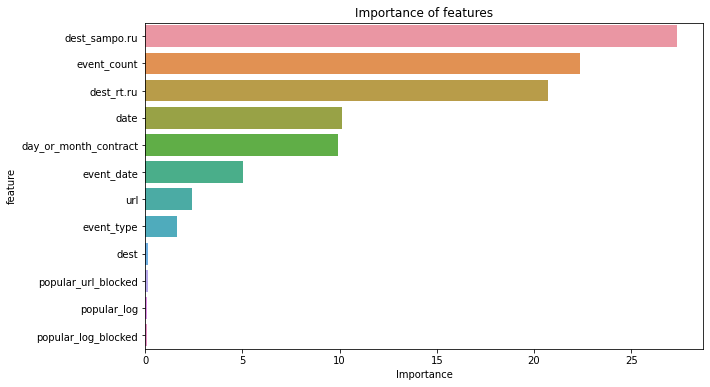

In [239]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
show_feature_importances(X_train.columns, cbc.feature_importances_)

In [240]:
final_test_pool = Pool(data=test_full.drop(['contract_id', 'blocked'], axis=1).fillna(0)
                       , cat_features=categorial_features)

In [241]:
pred = cbc.predict(final_test_pool)
pred

array([0, 0, 0, ..., 1, 1, 1])

In [217]:
pred.shape

(51956,)

In [242]:
test_data = pd.DataFrame(test_full['contract_id'].copy())
test_data['blocked'] = pred
test_data.drop_duplicates(subset=['contract_id'], keep='first', inplace=True)
test_data.set_index('contract_id', inplace=True)

In [243]:
test_data.to_csv('test_190922_2.csv')